In [1]:
import numpy as np
import os,sys


sys.path.append('../..')
sys.path.append('../../../RL_lib/Agents/PPO')
sys.path.append('../../../RL_lib/Utils')

%load_ext autoreload
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
import os
print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/briangaudet/Study/Subjects/MachineLearning/Projects/AAS_TEST_journal/RUN/AAS-18-290_6DOF_journal/Run/Run_4km_terminal


In [2]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

# Load Policy

6dof dynamics model
Quaternion_attitude
Thruster Config Shape:  (4, 6) 4
Inertia Tensor:  [[2000.    0.    0.]
 [   0. 2000.    0.]
 [   0.    0. 3200.]]
Lander Model: 
 - apf_v0:  70
 - apf_vf1:  [ 0.  0. -2.]
 - apf_vf2:  [ 0.  0. -1.]
 - apf_atarg:  15.0
 - apf_tau1:  20
 - apf_tau2:  100.0
Reward_terminal
queue fixed
Flat Constraint
Attitude Constraint


<IPython.core.display.Javascript object>


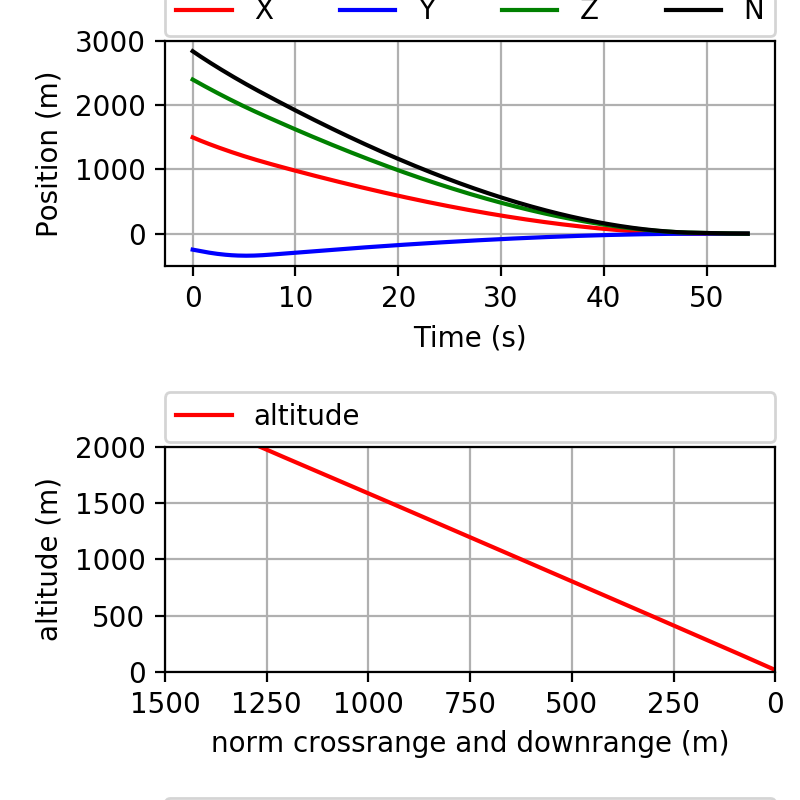

<IPython.core.display.Javascript object>


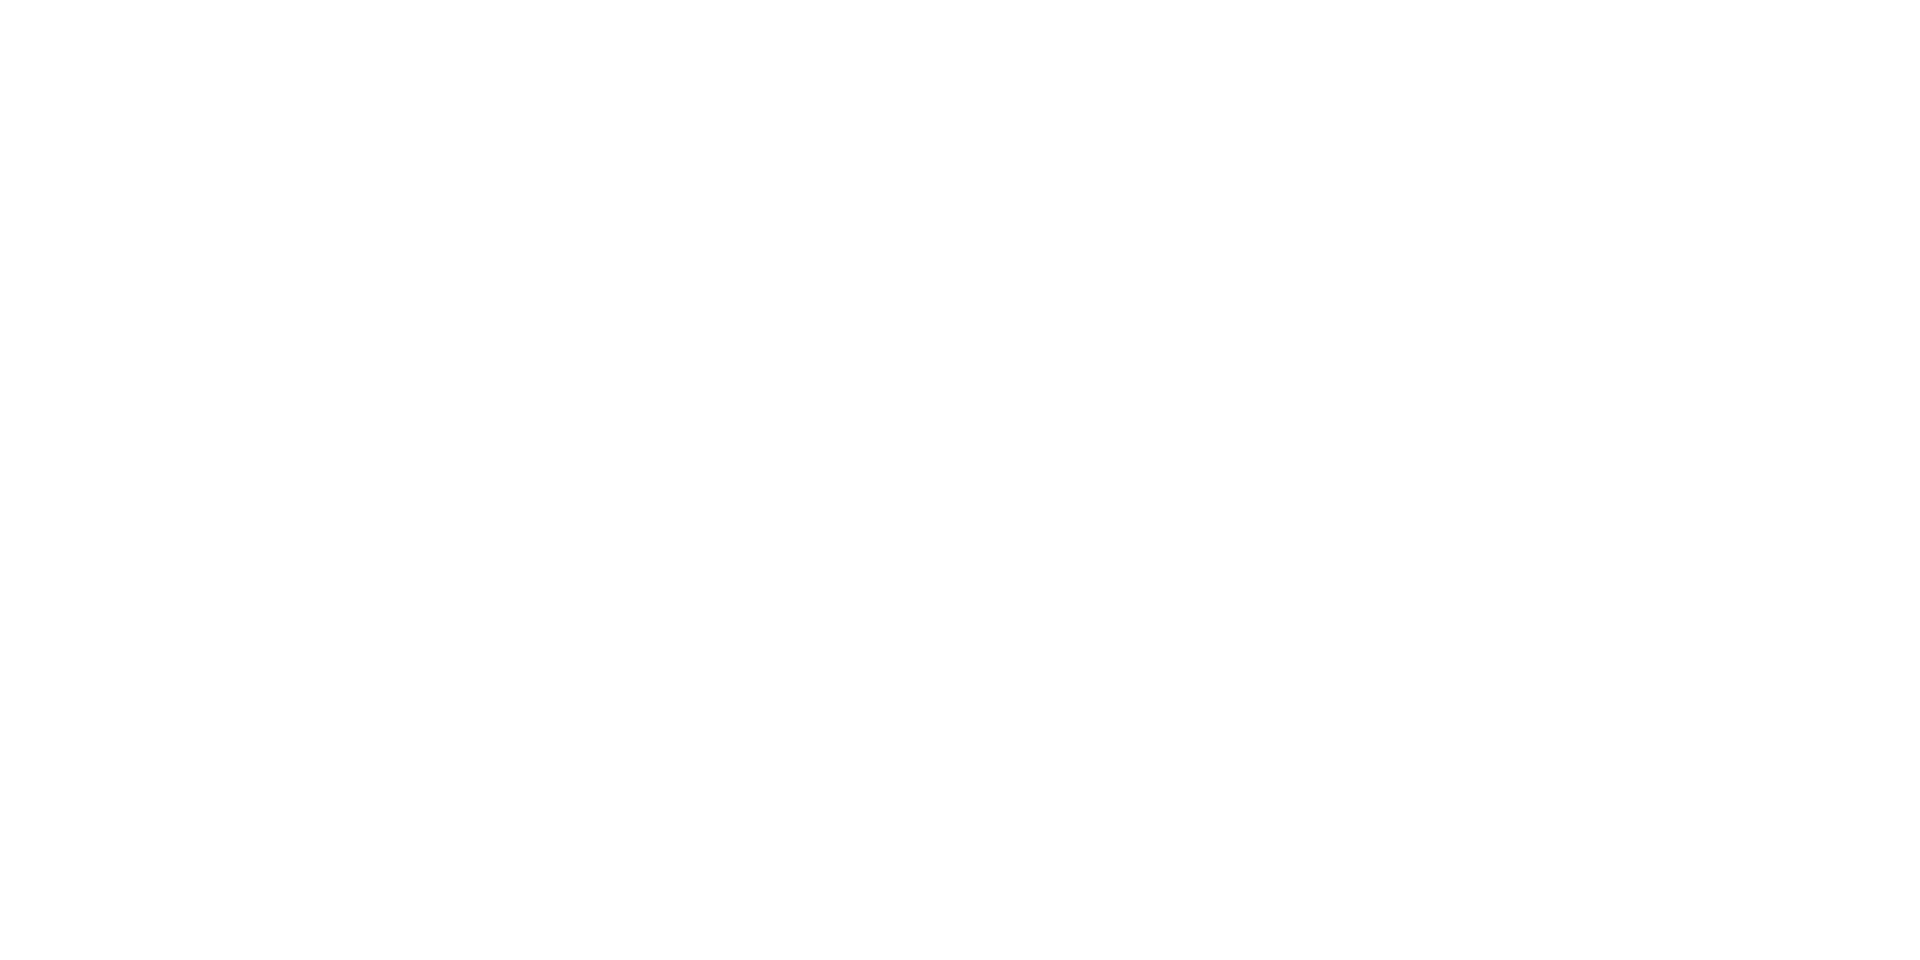

<IPython.core.display.Javascript object>


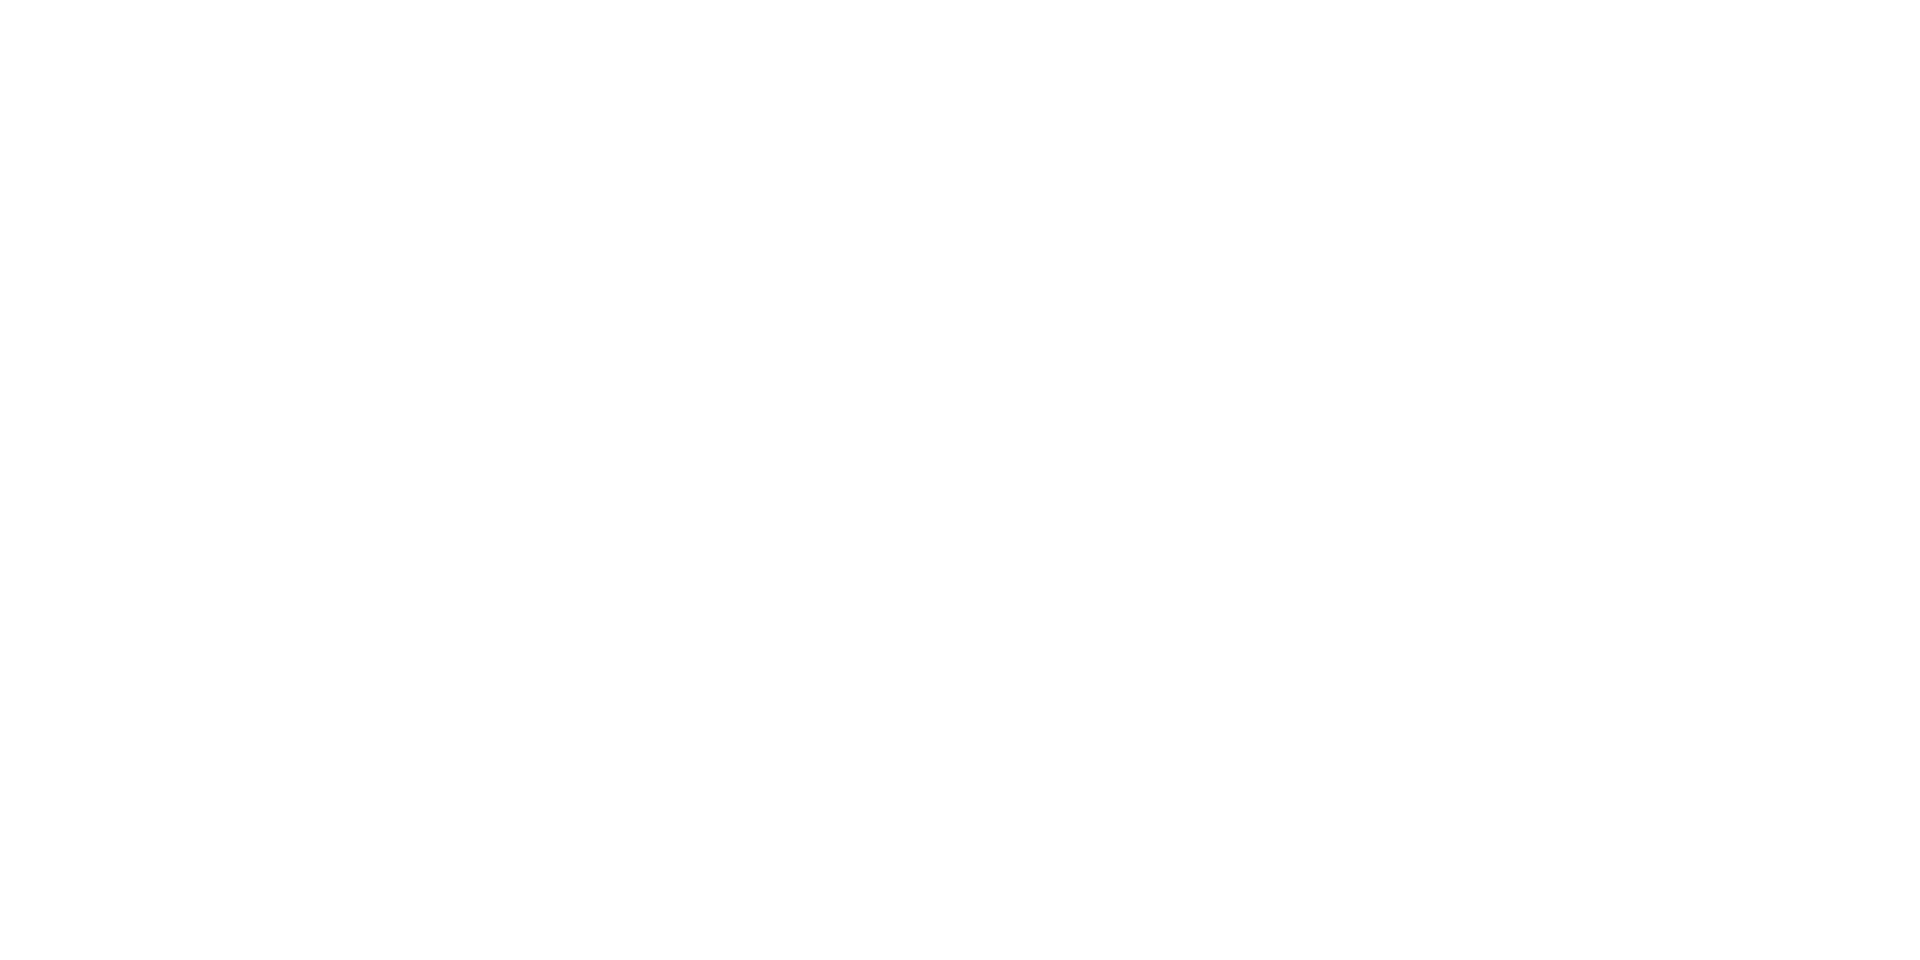

<IPython.core.display.Javascript object>


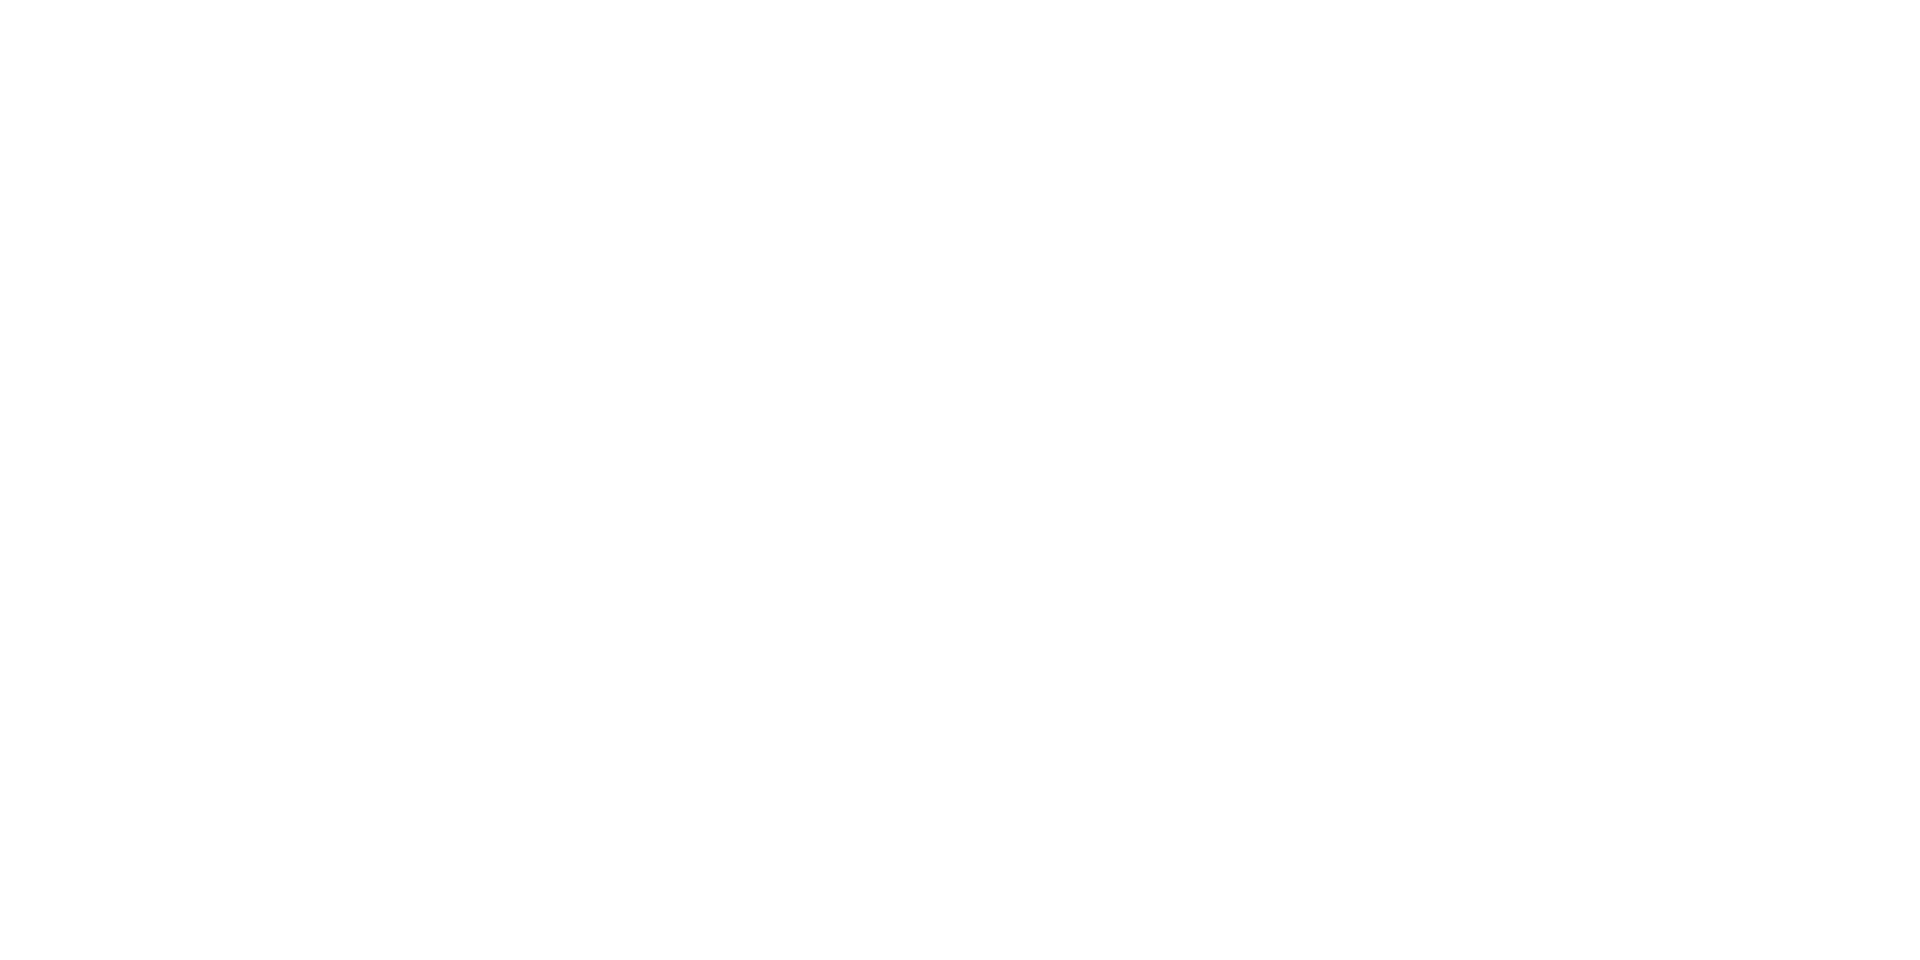

<IPython.core.display.Javascript object>


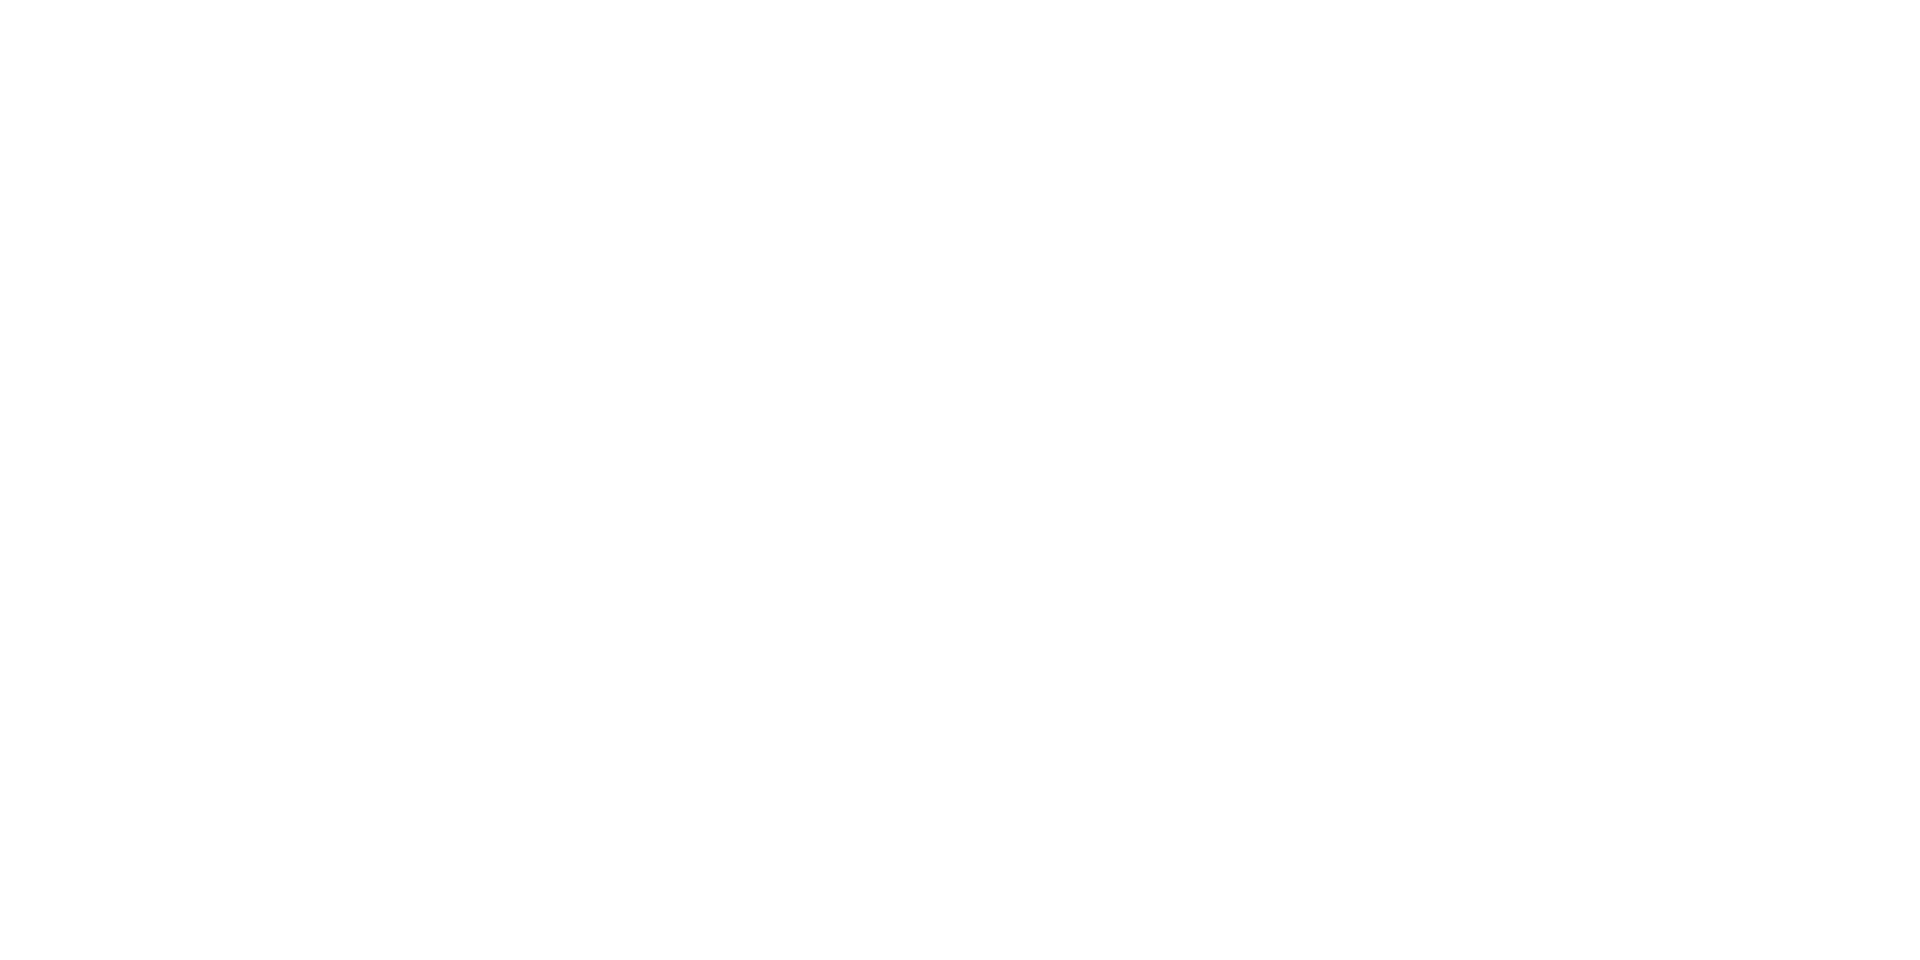

<IPython.core.display.Javascript object>


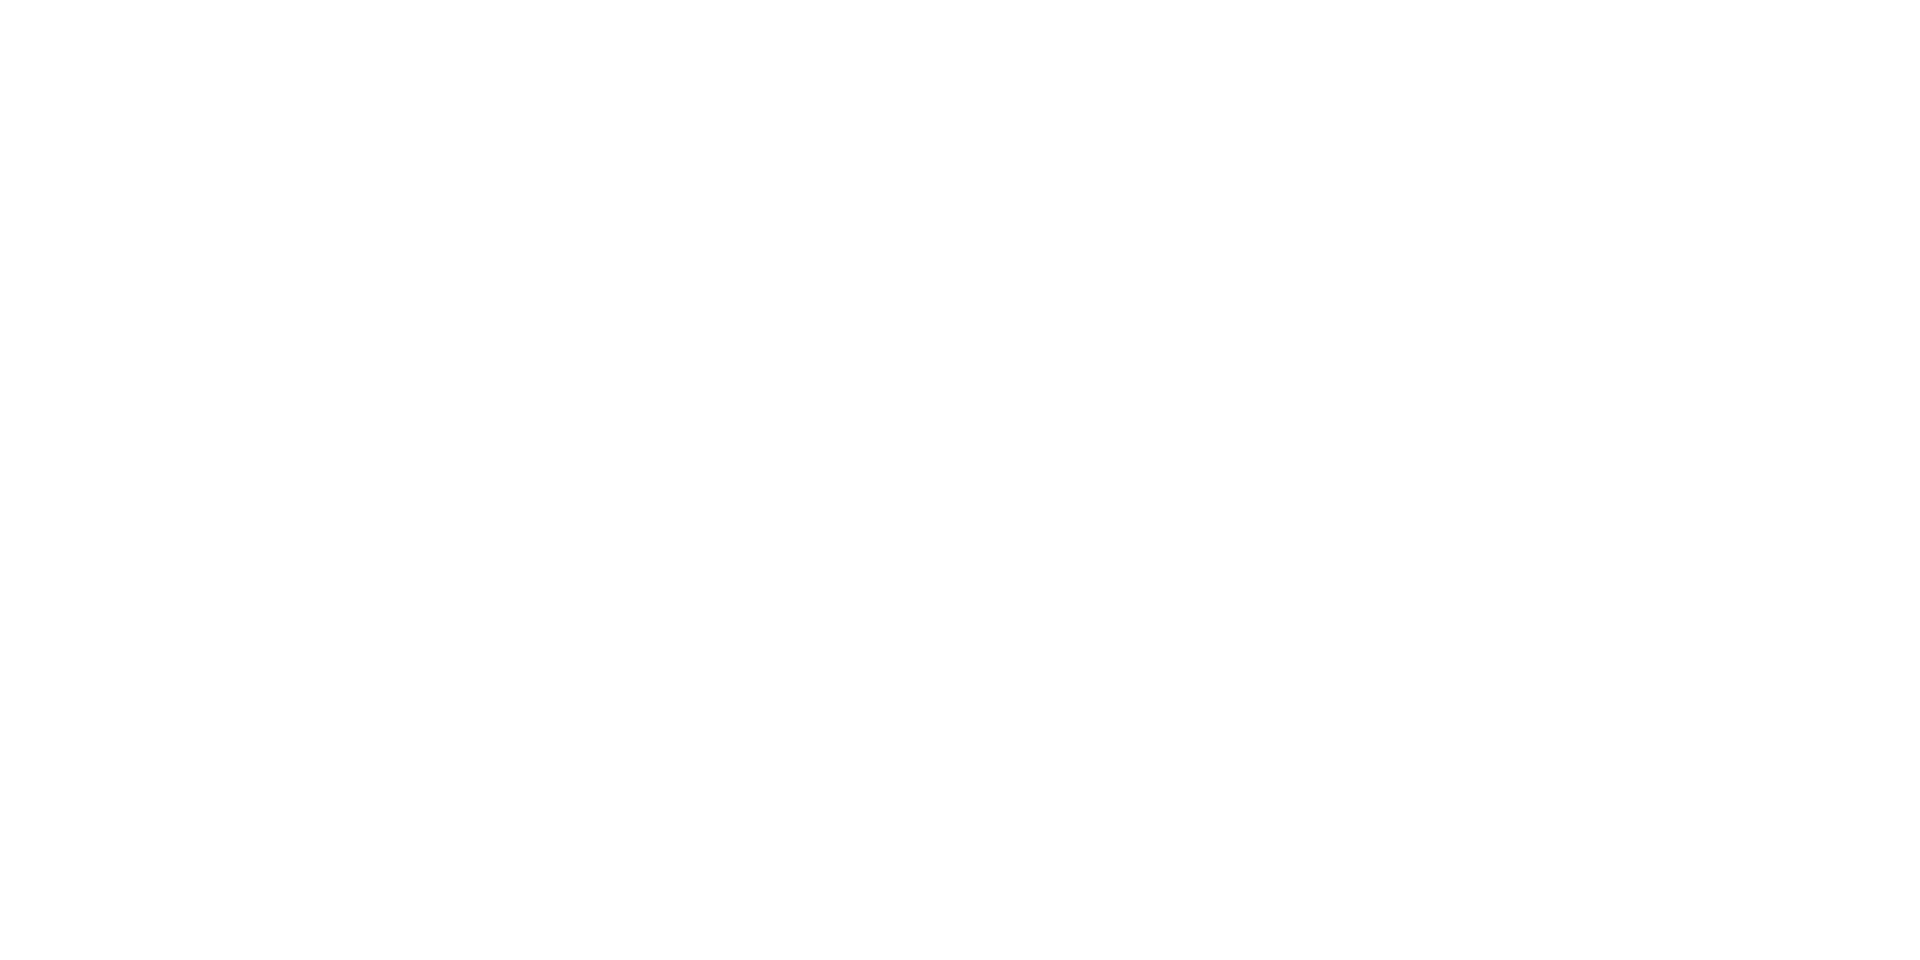

<IPython.core.display.Javascript object>


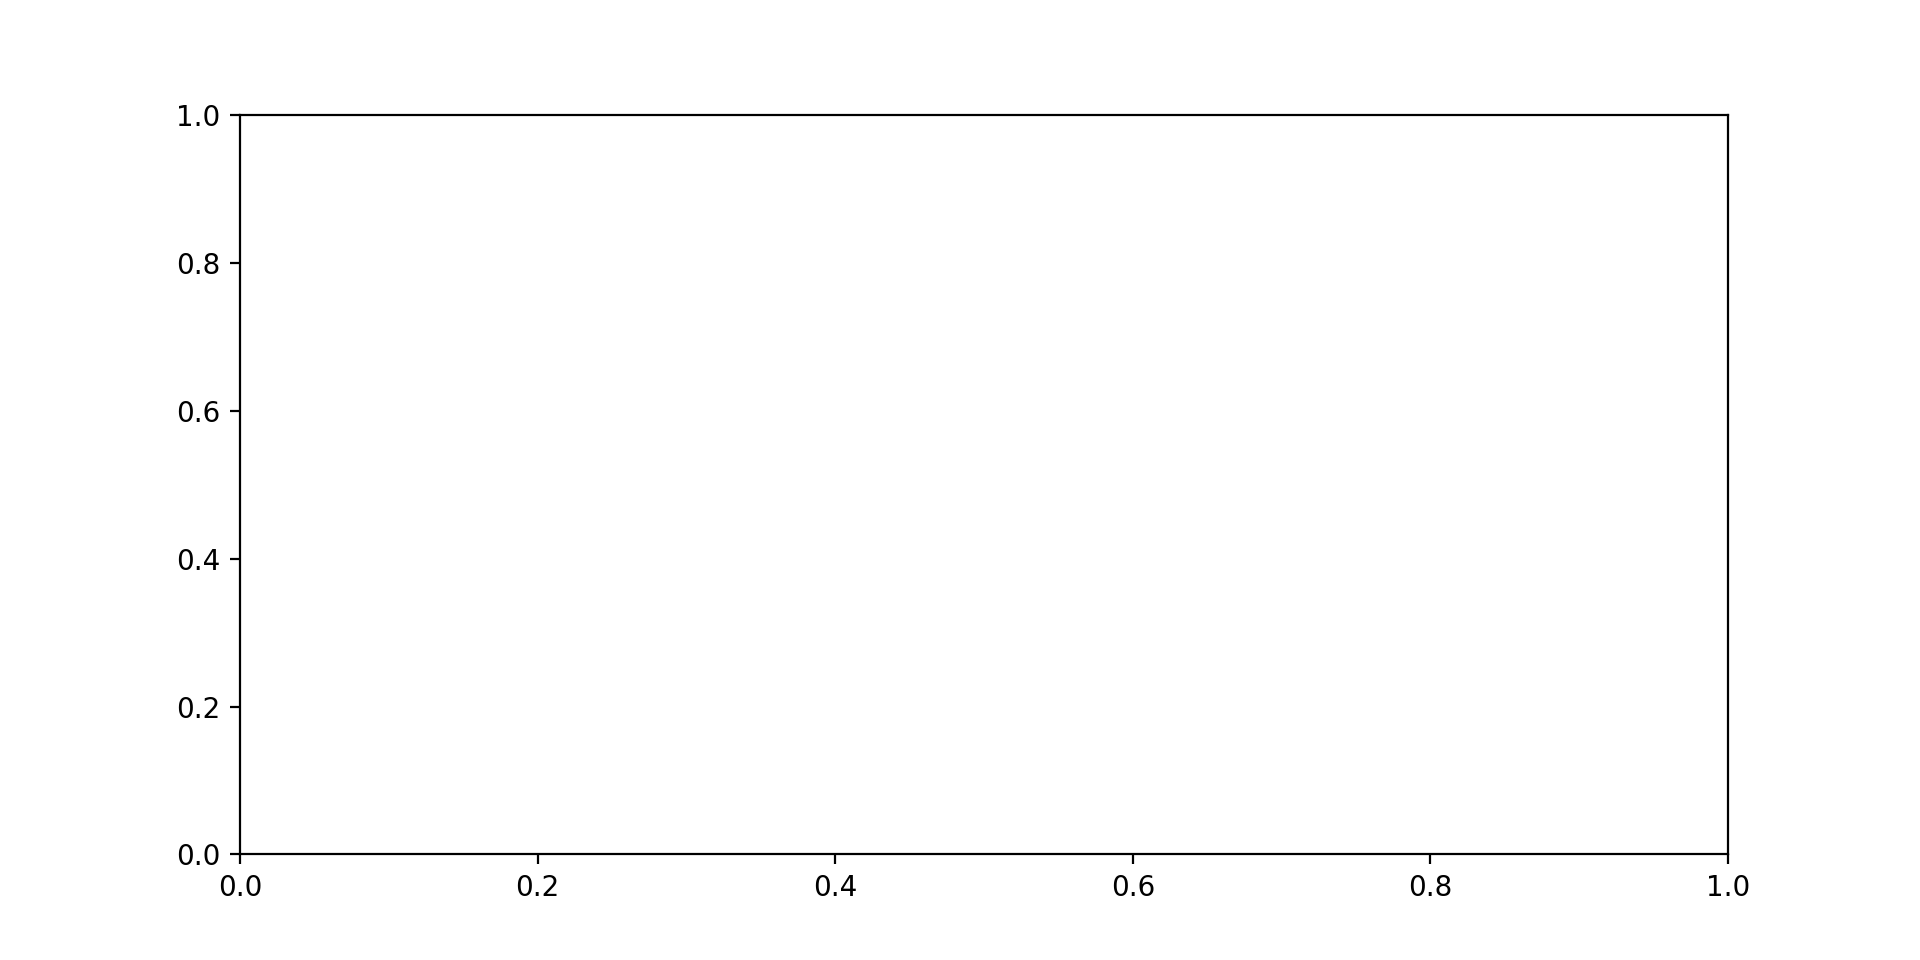

lander env att 2 fixed
Landing_icgen:
    downrange                   :  (0, 2000, -70, -10)
    crossrange                  :  (-1000, 1000, -30, 30)
    altitude                    :  (2300, 2400, -90, -70)
PPO Policy 1
Policy Params -- h1: 120, h2: 69, h3: 40, lr: 0.000108, logvar_speed: 8
[[-1.]
 [ 0.]
 [ 1.]]
10
Actor Test Mode:  False
clip param:  0.1
dict_keys(['h2/kernel:0', 'means/kernel:0', 'means/bias:0', 'h1/kernel:0', 'logvars:0', 'h2/bias:0', 'h1/bias:0', 'h3/bias:0', 'h3/kernel:0'])


In [3]:
from env_mdr import Env
from reward_terminal_mdr  import Reward
import env_utils as envu
import attitude_utils as attu
from dynamics_model import Dynamics_model
from lander_model import Lander_model
from ic_gen import Landing_icgen
from agent_mdr2 import Agent
from policy_ppo import Policy
from value_function import Value_function
from utils import Mapminmax,Logger,Scaler
from flat_constraint import Flat_constraint
from glideslope_constraint import Glideslope_constraint
from attitude_constraint import Attitude_constraint
from thruster_model import Thruster_model

logger = Logger()
dynamics_model = Dynamics_model()
attitude_parameterization = attu.Quaternion_attitude()

thruster_model = Thruster_model()
thruster_model.max_thrust = 5000
thruster_model.min_thrust = 1000

lander_model = Lander_model(thruster_model, attitude_parameterization=attitude_parameterization,
                           apf_v0=70, apf_atarg=15., apf_tau2=100.)
lander_model.get_state_agent = lander_model.get_state_agent_tgo_alt

reward_object = Reward(tracking_bias=0.01,tracking_coeff=-0.01, fuel_coeff=-0.05, debug=False, landing_coeff=10.)

glideslope_constraint = Glideslope_constraint(gs_limit=-1.0)
shape_constraint = Flat_constraint()
attitude_constraint = Attitude_constraint(attitude_parameterization, 
                                          attitude_penalty=-100,attitude_coeff=-10,
                                         attitude_limit=(10*np.pi, np.pi/2-np.pi/16, np.pi/2-np.pi/16))
env = Env(lander_model,dynamics_model,logger,
          reward_object=reward_object,
          glideslope_constraint=glideslope_constraint,
          shape_constraint=shape_constraint,
          attitude_constraint=attitude_constraint,
          tf_limit=120.0,print_every=10)


env.ic_gen = Landing_icgen(mass_uncertainty=0.05, 
                           g_uncertainty=(0.0,0.0), 
                           attitude_parameterization=attitude_parameterization,
                           l_offset=0.,
                           adapt_apf_v0=True,
                           inertia_uncertainty_diag=100.0, 
                           inertia_uncertainty_offdiag=10.0,
                           downrange = (0,2000 , -70, -10), 
                           crossrange = (-1000,1000 , -30,30),  
                           altitude = (2300,2400,-90,-70),
                           yaw   = (-np.pi/8, np.pi/8, 0.0, 0.0) ,
                           pitch = (np.pi/4-np.pi/8, np.pi/4+np.pi/16, -0.01, 0.01),
                           roll  = (-np.pi/8, np.pi/8, -0.01, 0.01))

env.ic_gen.show()

obs_dim = 12
act_dim = 4

policy = Policy(obs_dim,act_dim,kl_targ=0.001,epochs=20, beta=0.1, shuffle=True, servo_kl=True)
import utils
fname = "optimize_4km"
input_normalizer = utils.load_run(policy,fname)
print(input_normalizer)

# Test Policy over 4km

In [9]:
policy.test_mode=True
env.ic_gen = Landing_icgen(mass_uncertainty=0.05, g_uncertainty=(0.0,0.0),
                           adapt_apf_v0=True,
                           attitude_parameterization=attitude_parameterization,
                           downrange = (0,2000 , -70, -10), 
                           crossrange = (-1000,1000 , -30,30),  
                           altitude = (2300,2400,-90,-70),
                           yaw   = (-np.pi/8, np.pi/8, 0.0, 0.0) ,
                           pitch = (np.pi/4-np.pi/8, np.pi/4+np.pi/16, -0.0, 0.0),
                           roll  = (-np.pi/8, np.pi/8, -0.0, 0.0),
                          noise_u=100*np.ones(3), noise_sd=100*np.ones(3))
env.test_policy_batch(policy,input_normalizer,10000,print_every=100)

i :  100
Cumulative Stats (mean,std,max,argmax)
thrust   |9840.61 |3055.32 |3464.10 |20000.00 |    38
glideslope | 3.773 |12.345 | 0.583 |1400.016 |     5
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4    -0.1    -0.0 |     0.9     0.9     0.0 |    -1.3    -4.7    -0.0 |     5.4     1.8    -0.0
velocity |   0.063  -0.018  -0.927 |   0.025   0.042   0.066 |   0.012  -0.137  -1.100 |   0.103   0.060  -0.579
fuel     |291.71 | 16.02 |263.96 |331.28
attitude_321 |   0.022  -0.016   0.003 |   0.179   0.010   0.010 |  -0.390  -0.051  -0.022 |   0.354   0.007   0.028
w        |  -0.006  -0.006  -0.000 |   0.020   0.014   0.000 |  -0.067  -0.042  -0.000 |   0.043   0.036   0.000
glideslope |  23.539 |  15.748 |   8.914 | 117.094
i :  200
Cumulative Stats (mean,std,max,argmax)
thrust   |9818.34 |3070.98 |3464.10 |20000.00 |    38
glideslope | 3.889 |10.183 | 0.583 |1400.016 |     5
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Fin

i :  1200
Cumulative Stats (mean,std,max,argmax)
thrust   |9831.51 |3094.39 |3464.10 |20000.00 |    38
glideslope | 3.847 | 9.668 | 0.583 |2463.482 |   779
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4    -0.1    -0.0 |     0.7     0.7     0.0 |    -1.6    -4.7    -0.1 |     5.4     2.9    -0.0
velocity |   0.063  -0.015  -0.932 |   0.026   0.041   0.077 |  -0.043  -0.169  -1.341 |   0.147   0.122  -0.502
fuel     |291.73 | 15.71 |259.41 |342.69
attitude_321 |   0.014  -0.016   0.002 |   0.176   0.010   0.011 |  -0.498  -0.054  -0.034 |   0.552   0.018   0.043
w        |  -0.001  -0.005  -0.000 |   0.021   0.013   0.000 |  -0.117  -0.058  -0.000 |   0.071   0.061   0.000
glideslope |  21.869 |  15.297 |   8.829 | 256.680


KeyboardInterrupt: 


Cumulative Stats (mean,std,max,argmax)
thrust   |10615.23 |3050.20 |3464.10 |20000.00 |     0
glideslope | 4.211 |14.232 | 1.186 |168.971 |     0
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |    -0.3    -0.2    -0.0 |     0.0     0.0     0.0 |    -0.3    -0.2    -0.0 |    -0.3    -0.2    -0.0
velocity |   0.044  -0.033  -1.003 |   0.000   0.000   0.000 |   0.044  -0.033  -1.003 |   0.044  -0.033  -1.003
fuel     |278.73 |  0.00 |278.73 |278.73
attitude_321 |  -0.040  -0.003  -0.004 |   0.000   0.000   0.000 |  -0.040  -0.003  -0.004 |  -0.040  -0.003  -0.004
w        |  -0.012  -0.022  -0.000 |   0.000   0.000   0.000 |  -0.012  -0.022  -0.000 |  -0.012  -0.022  -0.000
glideslope |  55.459 |   0.000 |  55.459 |  55.459

Initial Stats (mean,std,min,max)
position |  1500.0   330.0  2400.0 |     0.0     0.0     0.0 |  1500.0   330.0  2400.0 |  1500.0   330.0  2400.0
velocity | -70.000 -30.000 -90.000 |   0.000   0.000   0.000 | -70.000 -3

<IPython.core.display.Javascript object>


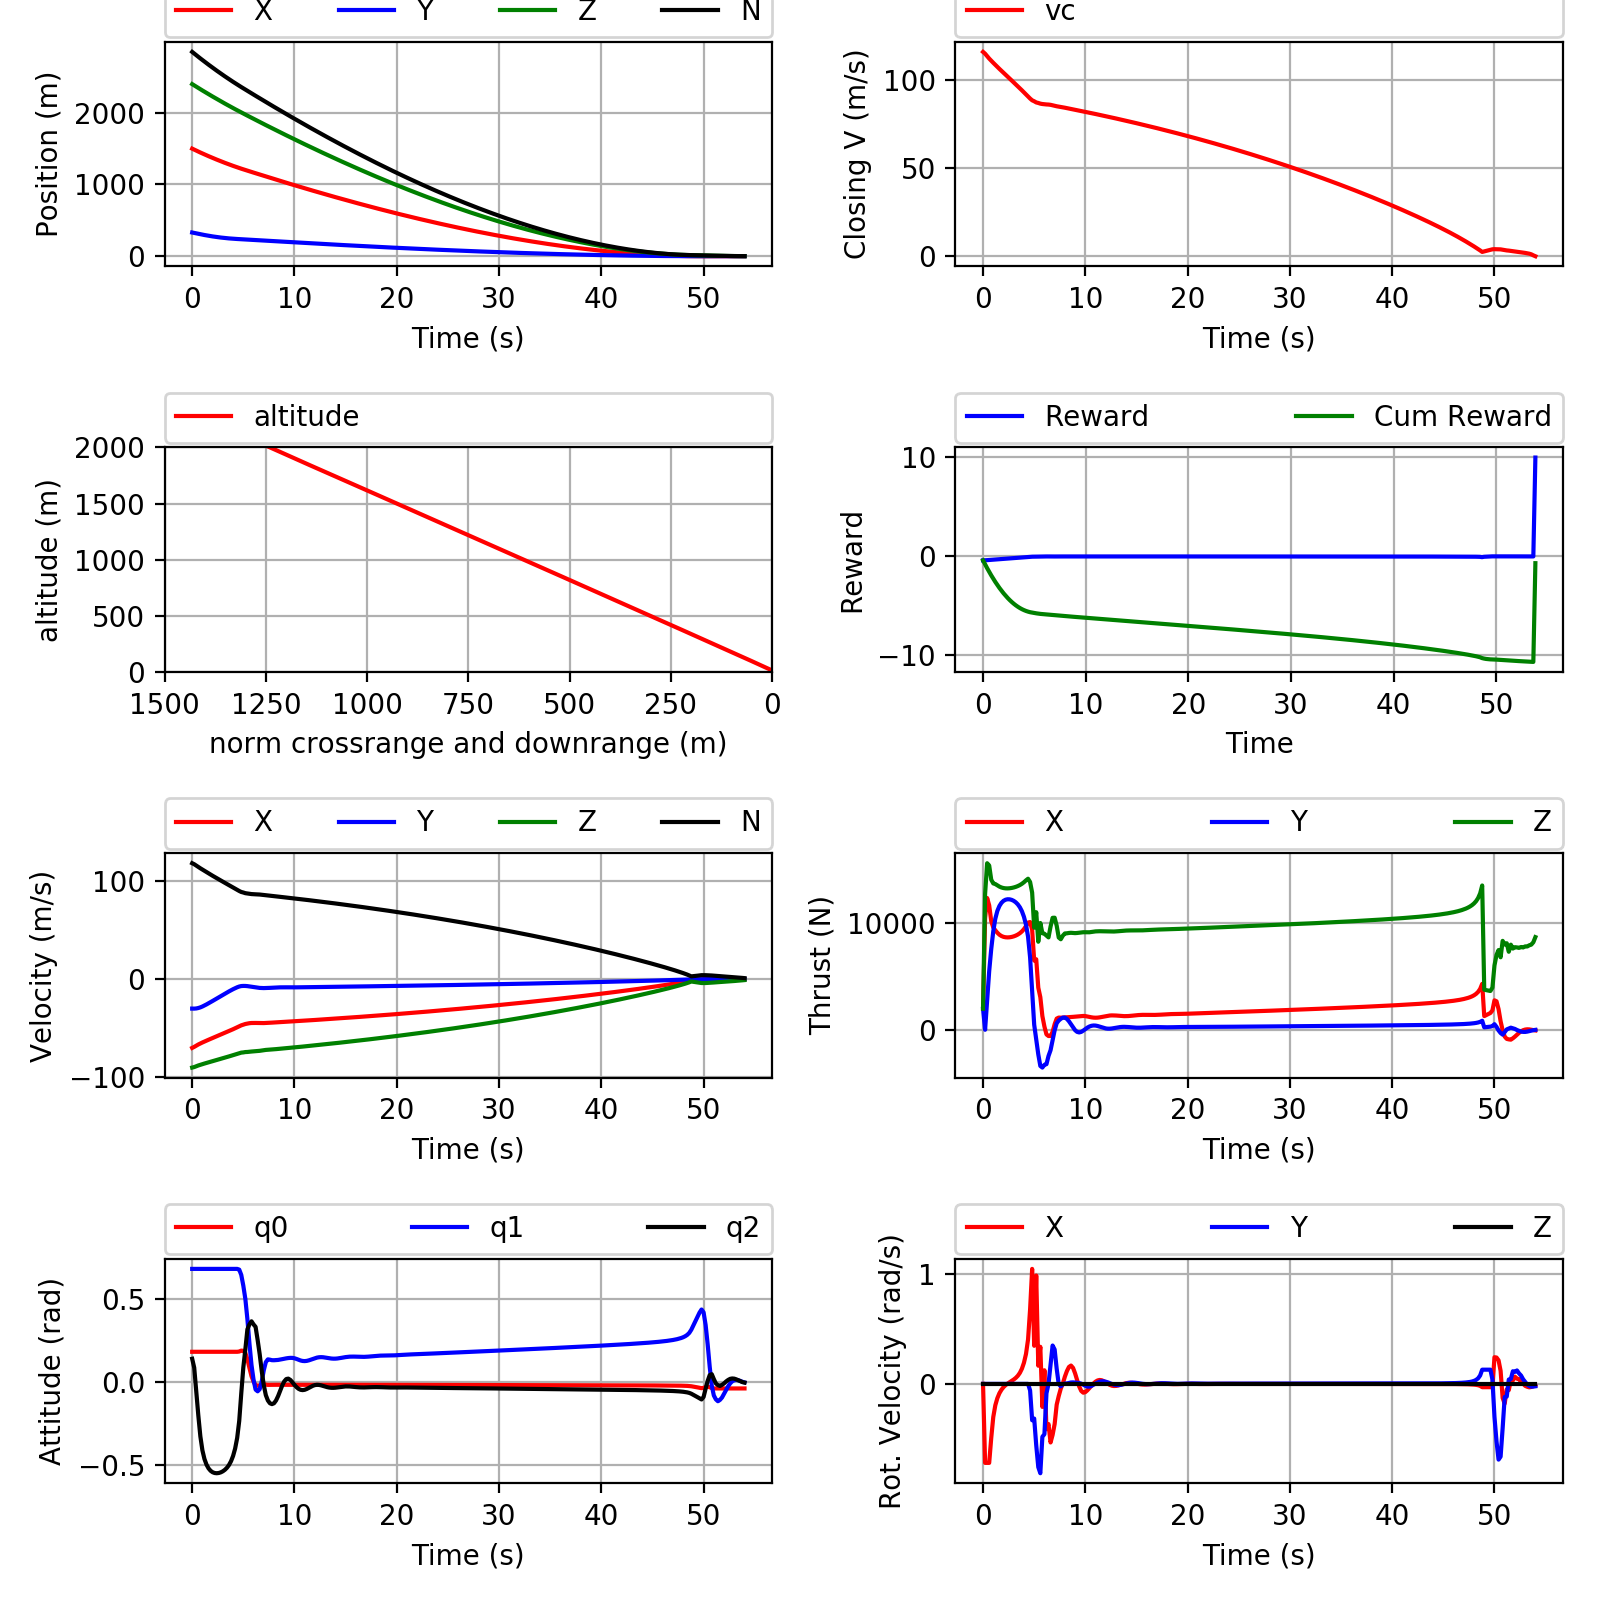

In [10]:
policy.test_mode=True
env.ic_gen = Landing_icgen(mass_uncertainty=0.0, g_uncertainty=(0.0,0.0),
                           adapt_apf_v0=True,
                           attitude_parameterization=attitude_parameterization,
                           downrange = (1500,1500 , -70, -70), 
                           crossrange = (-500,500 , -30,-30),  
                           altitude = (2400,2400,-90,-90),
                           yaw   = (-np.pi/8, np.pi/8, 0.0, 0.0) ,
                           pitch = (np.pi/4-np.pi/8, np.pi/4+np.pi/16, -0.0, 0.0),
                           roll  = (-np.pi/8, np.pi/8, -0.0, 0.0),
                          noise_u=0*np.ones(3), noise_sd=0*np.ones(3))
env.test_policy_batch(policy,input_normalizer,1,print_every=1)
envu.render_traj(lander_model.trajectory_list[0])

In [11]:
np.save("single_trajectory.npy",lander_model.trajectory_list[0])

In [ ]:
policy.close_sess()
